# Project

## Import statements + Device

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from utils import print_np_array_properties, imshow_batch, imshow_with_encoded_labels, get_encoded_attrs
from tqdm.notebook import tqdm, trange
import warnings
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")
%matplotlib inline

attr_dir = './data/CUB_200_2011/attributes.txt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available Device: {device}')

Available Device: cuda


## Dataset

In [2]:
# import pandas as pd

# df = pd.read_csv('data/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', delimiter= ' ')

# print(df)

attr_set = dict()

with open('data/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt') as file:
    
    for idx, line in enumerate(file):
                
        img_id, attr_id= line.split(' ')[0], line.split(' ')[1]
        
        
        attr_value = 1 if int(line.split(' ')[2]) ==1 and int(line.split(' ')[3]) >= 3 else 0
        
        if img_id not in attr_set:
            attr_set[img_id]= [attr_value]       
        else:
            attr_set[img_id].append(attr_value)
            

            
x = [encoding for key, encoding in attr_set.items()] 

x = torch.tensor(x)

print_np_array_properties(x)



=============== np array Properties =============

np array:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])
np array_dtype: torch.int64
np array_shape: torch.Size([11788, 312])
np array_size: <built-in method size of Tensor object at 0x7fa013506200>



### Custom Dataset

In [3]:
class CUB_200_2011(datasets.ImageFolder):
    """Custom dataset that includes image paths. Extends
    torchvision.datasets.ImageFolder
    """
    
    def __init__(self, img_id_file = 'data/CUB_200_2011/CUB_200_2011/images.txt' , attrs_label_file = 'data/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', *args, **kwargs):
        
        super().__init__(*args, **kwargs)
        
        attr_set = dict()

        with open(attrs_label_file) as file:

            for idx, line in enumerate(file):

                img_id, attr_id= line.split(' ')[0], line.split(' ')[1]


                attr_value = 1 if int(line.split(' ')[2]) ==1 and int(line.split(' ')[3]) >= 3 else 0

                if img_id not in attr_set:
                    attr_set[img_id]= [attr_value]       
                else:
                    attr_set[img_id].append(attr_value)
            
        x = [encoding for key, encoding in attr_set.items()] 

        self.encoded_attrs = torch.tensor(x)
        
        img_id_dict = dict()
        with open(img_id_file) as file:
            for line in file:
                line=line.rstrip()
                img_id, img_label= line.split(' ')[0], line.split('/')[1]
                img_id_dict[img_label]= img_id
                
        self.img_id_dict = img_id_dict

    # override the __getitem__ method that dataloader calls
    def __getitem__(self, index):
        
        path, target = self.imgs[index]
        img = self.loader(path)
        img_label = path.split('/')[-1]
        img_id = self.img_id_dict[img_label]
        img_idx = int(img_id)-1
        
        attrs = self.encoded_attrs[img_idx]
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, attrs
    
    def __len__(self):
        return len(self.imgs)


### Download Dataset

tensor([120,   6, 174,  76,  80,   7,  44, 143, 100, 190, 185, 163,   9,  77,
         19,  82, 109, 167,  38,  76, 142,  37, 117, 155, 144,   7,  32,  10,
         10, 172, 159, 138,  90, 155, 117,  76,  49,  22,  51,  65,  46, 160,
         40,  67, 175,  36, 129,  85, 105,   3,  81,  11,  27, 138,   8,  85,
         98,  70, 116,  17, 194, 174, 134, 155])
torch.Size([64, 312])


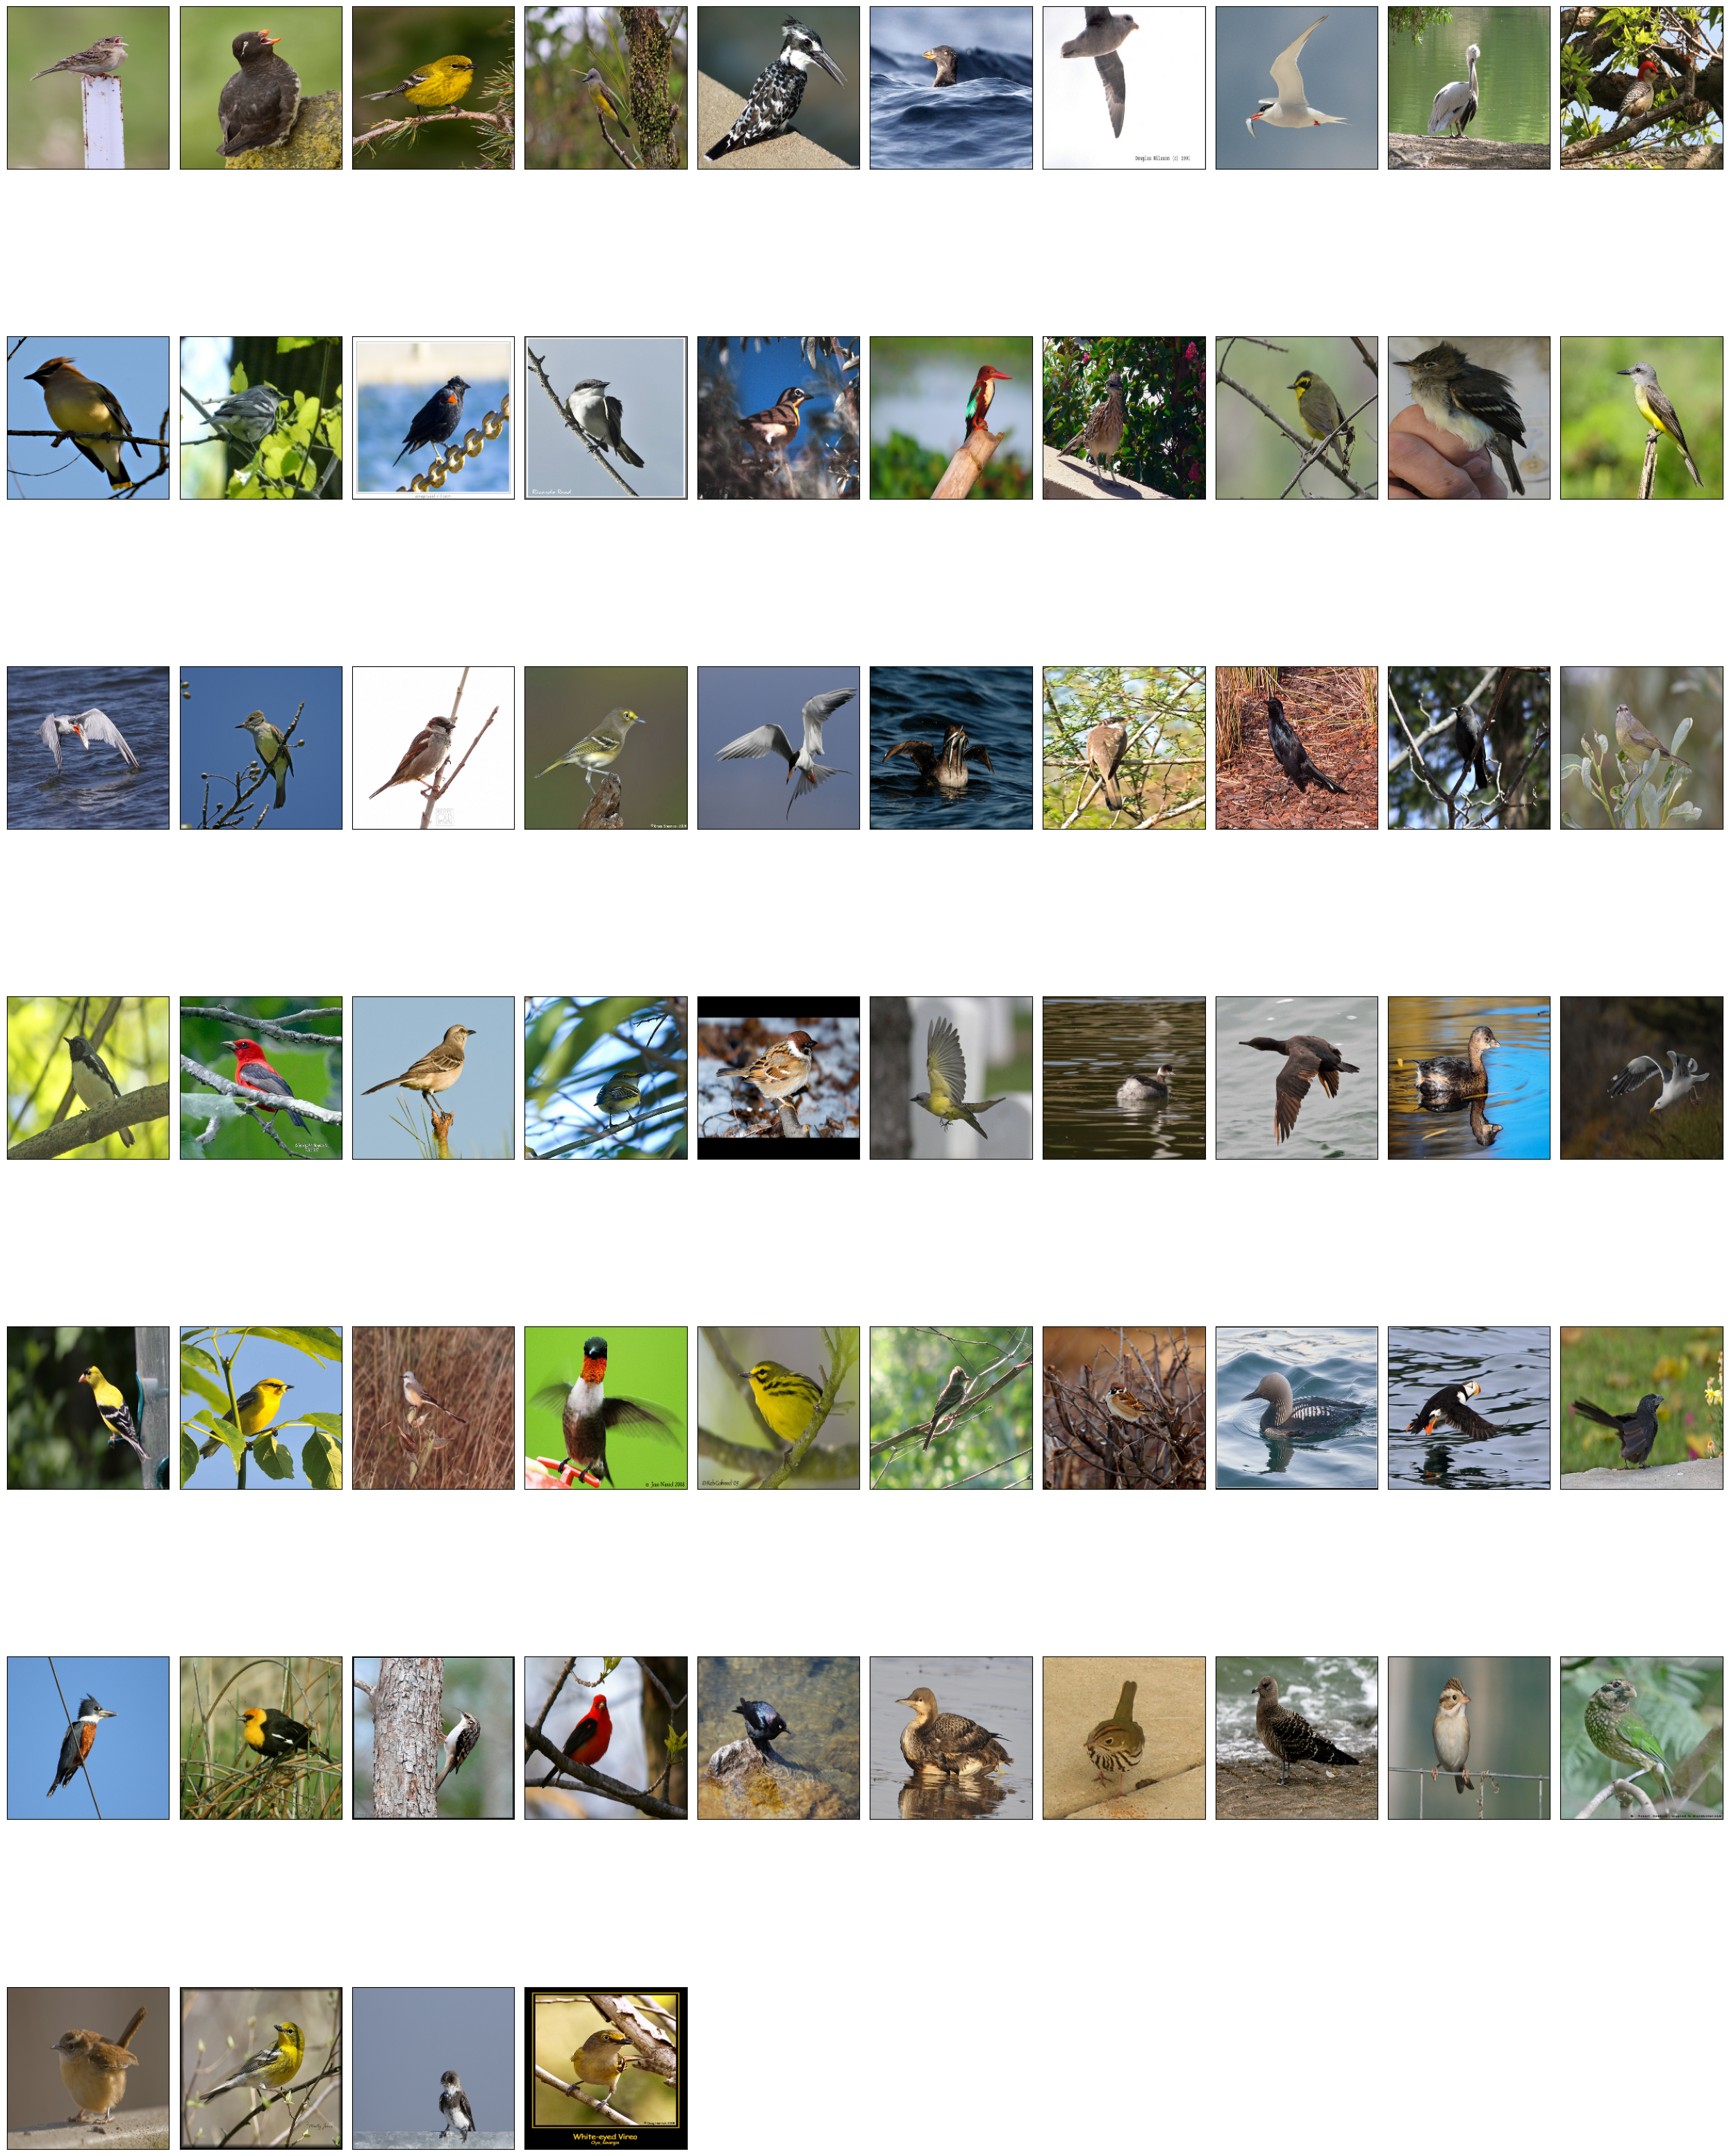

In [5]:
num_workers = 0
# how many samples per batch to load
batch_size = 64

## Define preprocessing transformation applied to data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
    ])


data = CUB_200_2011(
    root='./data/CUB_200_2011/CUB_200_2011/images/',
    transform = transform
)

# print(data.imgs)

loader = torch.utils.data.DataLoader(data, batch_size=batch_size, num_workers=num_workers, shuffle=True)



with open(attr_dir) as file:
    attrs = [attr.rstrip().split(' ')[1] for attr in file]    

# print(attrs)

dataiter = iter(loader)
images, labels, attrs = next(dataiter)

print(labels)

print(attrs.shape)


# print(images.shape)

imshow_batch(batch_size, images)
